In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import collections
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import umap


Pfad Parquet File: /dtu/blackhole/1a/222266/embeddings.parquet

In [6]:
#Expectes data to be in the same directory as the notebook in a folder called 'data'
#Read in cleaned file after all the preprocessing steps
path_book_ratings = "/zhome/0f/8/221869/compToolsForDs/data/Books_rating_cleaned_new_eng.csv"
br = pd.read_csv(path_book_ratings)

In [7]:
# create random sample of 10000 reviews
br = br.sample(n=10000, random_state=42).reset_index(drop=True)

## Embedding Creation



In [8]:
model = SentenceTransformer('all-MiniLM-L6-v2')
reviews = br['cleanText'].tolist()
embeddings = model.encode(
    reviews,
    batch_size=64,           # tune based on your memory / GPU
    show_progress_bar=True,
    convert_to_numpy=True    # returns a NumPy array
)



Batches: 100%|██████████| 157/157 [06:02<00:00,  2.31s/it]


In [9]:
embeddings.shape

(10000, 384)

## K-means with k = 5
Todo: 
- try different number of clusters ✅
- Compute average score/score distribution per cluster
- Try different Hyperparameters for UMAP
- Try t-SNE
- Compute score for Clustering

In [ ]:
#try clustering the embeddings
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# Fit KMeans on embeddings
labels = kmeans.fit_predict(embeddings)

# labels[i] is the cluster of embeddings[i]
print(labels[:20])  # show the first 20 cluster assignments

# Add cluster labels to the original dataframe
br["cluster"] = labels

# See cluster counts
print(br["cluster"].value_counts())

[4 0 0 4 2 4 0 4 3 0 3 4 2 4 4 3 4 2 1 2]
cluster
4    2890
0    2436
2    1895
1    1840
3     939
Name: count, dtype: int64


In [19]:
br.head()

,Id,review/score,cleanText,lang,cluster
0,B000HYTF96,5.0,I took this book on vacation thinking that I w...,en,4
1,B000Q9I494,5.0,"hey, ive been wondering why was tom bombadil e...",en,0
2,B00085ZGFG,5.0,"""Crime and Punishment"" was my introduction to ...",en,0
3,B000E1EJ3Y,4.0,This book asks some interesting questions in s...,en,4
4,B0007HVO0Q,1.0,Quantim mechanics in general requires high lev...,en,2


Normalized review score distribution per cluster:
review/score       1.0       2.0       3.0       4.0       5.0
cluster                                                       
0             0.081281  0.057061  0.098522  0.229475  0.533662
1             0.053804  0.055978  0.104891  0.245109  0.540217
2             0.074406  0.046438  0.074406  0.168865  0.635884
3             0.060703  0.028754  0.050053  0.168264  0.692226
4             0.062976  0.036678  0.078547  0.184775  0.637024

Absolute review score counts per cluster:
review/score  1.0  2.0  3.0  4.0   5.0
cluster                               
0             198  139  240  559  1300
1              99  103  193  451   994
2             141   88  141  320  1205
3              57   27   47  158   650
4             182  106  227  534  1841


<Figure size 1000x600 with 0 Axes>

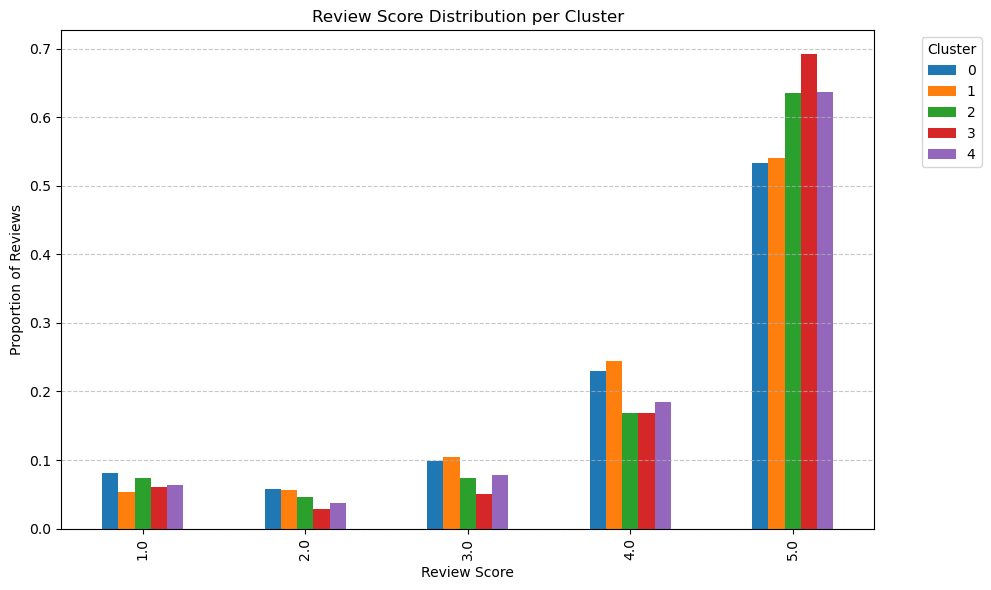

In [23]:
# --- Group by cluster and compute score distribution ---
score_counts = br.groupby("cluster")["review/score"].value_counts(normalize=True).unstack(fill_value=0)

print("Normalized review score distribution per cluster:")
print(score_counts)

# --- Optional: also get absolute counts ---
score_counts_abs = br.groupby("cluster")["review/score"].value_counts().unstack(fill_value=0)
print("\nAbsolute review score counts per cluster:")
print(score_counts_abs)

# --- Plot the distributions ---
plt.figure(figsize=(10, 6))
score_counts.T.plot(kind="bar", figsize=(10, 6))
plt.title("Review Score Distribution per Cluster")
plt.xlabel("Review Score")
plt.ylabel("Proportion of Reviews")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

/zhome/0f/8/221869/miniforge3/envs/text-embeddings/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


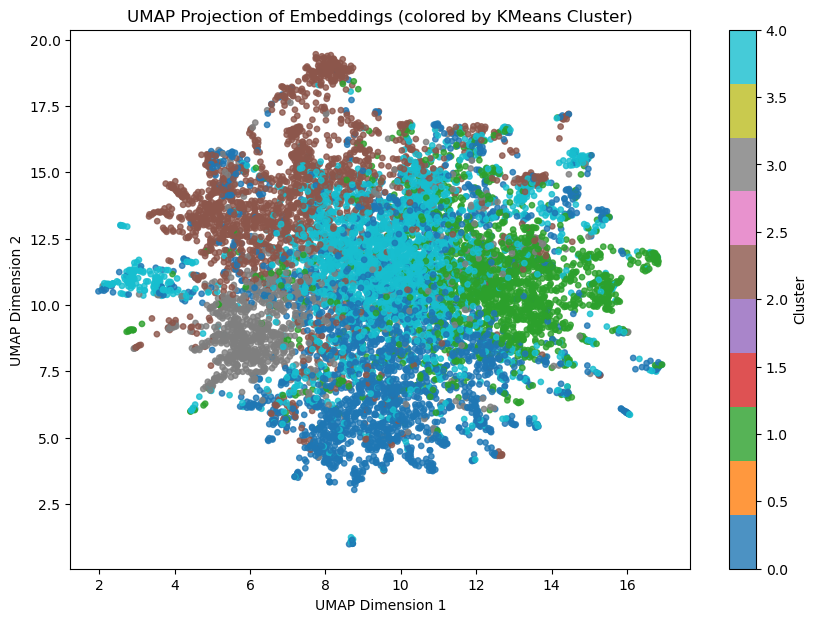

In [12]:
reducer = umap.UMAP(n_neighbors=5, min_dist=0.4, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# --- Visualization ---
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=labels,
    cmap='tab10',  # or 'Spectral', 'viridis', etc.
    s=15,
    alpha=0.8
)
plt.colorbar(scatter, label='Cluster')
plt.title("UMAP Projection of Embeddings (colored by KMeans Cluster)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

/zhome/0f/8/221869/miniforge3/envs/text-embeddings/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


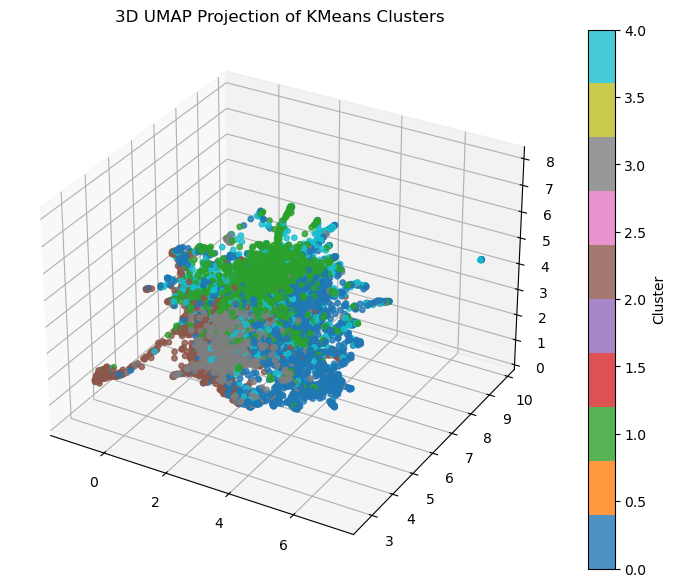

In [27]:
from mpl_toolkits.mplot3d import Axes3D

reducer_3d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
embedding_3d = reducer_3d.fit_transform(embeddings)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2],
               c=labels, cmap='tab10', s=15, alpha=0.8)
fig.colorbar(p, label='Cluster')
ax.set_title("3D UMAP Projection of KMeans Clusters")
plt.show()


## Compute Davies-Bouldin Index

In [24]:
# Compute Davies
# Compute Davies–Bouldin Index
db_index = davies_bouldin_score(embeddings, labels)
print(f"Davies–Bouldin Index: {db_index:.4f}")

Davies–Bouldin Index: 4.9605


## K-means with k = [2, 10]


k= 2 | Davies–Bouldin Index=5.9187 | Inertia=7280.11
k= 3 | Davies–Bouldin Index=5.3259 | Inertia=7131.31
k= 4 | Davies–Bouldin Index=5.1172 | Inertia=7033.14
k= 5 | Davies–Bouldin Index=4.9605 | Inertia=6966.54
k= 6 | Davies–Bouldin Index=5.2809 | Inertia=6914.33
k= 7 | Davies–Bouldin Index=5.0967 | Inertia=6861.16
k= 8 | Davies–Bouldin Index=5.2568 | Inertia=6815.99
k= 9 | Davies–Bouldin Index=5.0576 | Inertia=6768.26
k=10 | Davies–Bouldin Index=5.0095 | Inertia=6735.03


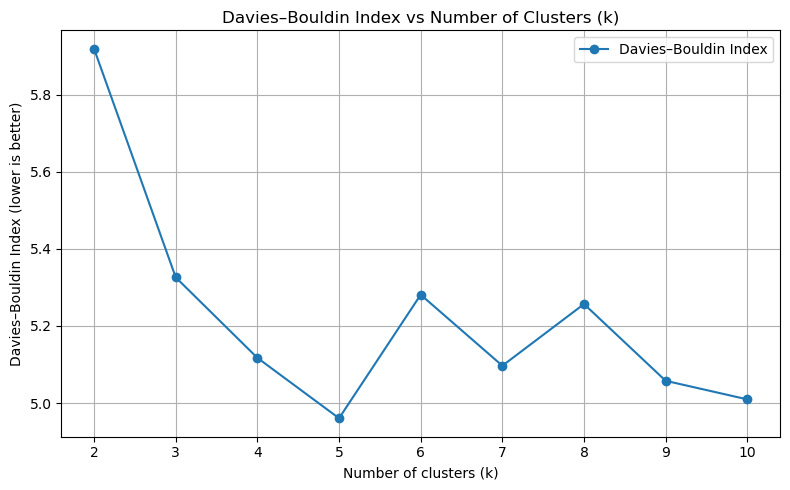

In [16]:
# === Step 2: Run KMeans for k = 2..10 and compute Davies–Bouldin Index ===
k_values = range(2, 11)
db_scores = []


for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    db_index = davies_bouldin_score(embeddings, labels)
    inertia = kmeans.inertia_

    db_scores.append(db_index)
    inertias.append(inertia)

    print(f"k={k:2d} | Davies–Bouldin Index={db_index:.4f} | Inertia={inertia:.2f}")

# === Step 3: Plot the results ===
plt.figure(figsize=(8, 5))
plt.plot(k_values, db_scores, marker='o', linestyle='-', label='Davies–Bouldin Index')
plt.title("Davies–Bouldin Index vs Number of Clusters (k)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Davies–Bouldin Index (lower is better)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
X = StandardScaler().fit_transform(embeddings)
labels = dbscan.fit_predict(X)

## DBSCAN

In [32]:
# === Step 3: Run DBSCAN ===
# eps: max distance between two samples for them to be considered neighbors
# min_samples: number of points required to form a dense region
dbscan = DBSCAN(eps=0.25)
X = StandardScaler().fit_transform(embeddings)
labels = dbscan.fit_predict(X)

# === Step 4: Add cluster labels to your DataFrame ===
br["cluster_dbscan"] = labels

# === Step 5: Inspect results ===
# DBSCAN labels: -1 = noise (unclustered points)
print("Cluster label counts:")
print(br["cluster_dbscan"].value_counts().sort_index())

# Optional: check how many noise points
n_noise = (labels == -1).sum()
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"\nNumber of clusters found: {n_clusters}")
print(f"Number of noise points: {n_noise}")

Cluster label counts:
cluster_dbscan
-1    10000
Name: count, dtype: int64

Number of clusters found: 0
Number of noise points: 10000


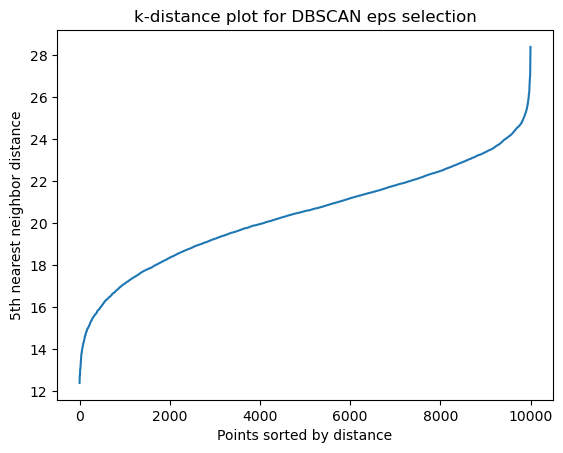

In [33]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=5)  # min_samples = 5
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances[:, 4])  # 4 because 0-indexed

plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("5th nearest neighbor distance")
plt.title("k-distance plot for DBSCAN eps selection")
plt.show()


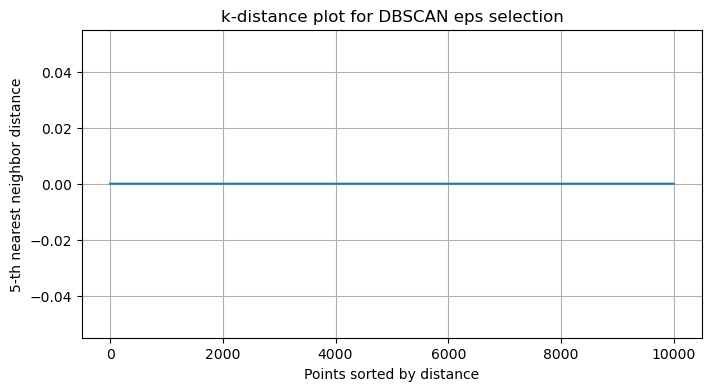


Cluster label counts:
cluster_dbscan
0     1841
1     1300
2      534
3      141
4      182
5      650
6      240
7     1205
8      320
9      994
10     559
11     198
12      47
13     451
14     193
15     139
16     227
17     103
18     106
19     158
20     141
21      57
22      27
23      88
24      99
Name: count, dtype: int64

Number of clusters found: 25
Number of noise points: 0


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# --- Step 1: Prepare embeddings ---
"""
if "embedding" in br.columns:
    embeddings = np.vstack(br["embedding"].values)
else:
    embeddings = br.select_dtypes(include=[float, int]).values

print("Embeddings shape:", embeddings.shape)

"""
# --- Step 2: Scale embeddings (important for distance-based clustering) ---
X = StandardScaler().fit_transform(embeddings)

# --- Step 3: Compute k-distance to estimate eps ---
min_samples = 5  # you can adjust this
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sort the distances to the k-th nearest neighbor
k_distances = np.sort(distances[:, min_samples - 1])  # 0-indexed
plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples}-th nearest neighbor distance")
plt.title("k-distance plot for DBSCAN eps selection")
plt.grid(True)
plt.show()

# --- Step 4: Choose eps based on the "knee" of the plot ---
# Manual inspection: pick eps where the curve sharply increases
# Example: eps = 0.5 (adjust after inspecting the plot)
eps = 0.5

# --- Step 5: Run DBSCAN ---
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
labels = dbscan.fit_predict(X)

# --- Step 6: Add cluster labels to DataFrame ---
br["cluster_dbscan"] = labels

# --- Step 7: Inspect results ---
print("\nCluster label counts:")
print(br["cluster_dbscan"].value_counts().sort_index())

n_noise = (labels == -1).sum()
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"\nNumber of clusters found: {n_clusters}")
print(f"Number of noise points: {n_noise}")


In [30]:
br.head()

,Id,review/score,cleanText,lang,cluster,cluster_dbscan
0,B000HYTF96,5.0,I took this book on vacation thinking that I w...,en,4,-1
1,B000Q9I494,5.0,"hey, ive been wondering why was tom bombadil e...",en,0,-1
2,B00085ZGFG,5.0,"""Crime and Punishment"" was my introduction to ...",en,0,-1
3,B000E1EJ3Y,4.0,This book asks some interesting questions in s...,en,4,-1
4,B0007HVO0Q,1.0,Quantim mechanics in general requires high lev...,en,2,-1


## Read Embeddings from Parquet File
Pfad: /dtu/blackhole/1a/222266/embeddings.parquet